In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eigvalsh
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jax import jit, vmap, grad, value_and_grad

from configs import Lorenz96Config, LorenzSystem
from models import lorenz96_step 
from metrics import rmse, mbe
from plotting import plot_rmse_stackplot, plot_cross_val

from cost_functions import (
    bayes_cost_function,
    dci_cost_function,
    dci_wme_cost_function,
)

import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
jax.config.update("jax_enable_x64", True)

In [35]:
"""Main execution function"""
# Define cost functions
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

dofs = [12, 24, 36, 48, 64]
inf_factors = [5, 5, 5,5, 5]
dof_dfs = []
for dof, level in zip(dofs,inf_factors):
    print(f"dof: {dof}, level: {level}")
    # Create system with default configuration
    config_96 = Lorenz96Config.default_config(
                                        state_dim=dof,
                                        obs_dim=dof//2,
                                        total_steps=500,
                                        window_size=20,
                                        obs_frequency=4,
                                        obs_std=1.2,
                                        inflation_factor=level,
                                        seed=13
                                        )
    system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
    system_96.obs_system._setup_observation_operator()
    results_96 = system_96.run_experiment()
    dof_dfs.append(pd.DataFrame.from_dict(results_96['results'], orient='index'))


rmse_dofs = pd.concat(map(lambda df: df.rmse, dof_dfs),axis=1).T.reset_index(drop=True)
rmse_dofs.index = dofs

dof: 12, level: 5
dof: 24, level: 5
dof: 36, level: 5
dof: 48, level: 5
dof: 64, level: 5


In [5]:
rmse_dofs

,Bayes,DCI,DCI_WME
12,0.574385,0.888846,1.010530
24,0.895116,1.538437,0.856875
36,0.805263,1.459292,0.783561
48,1.549806,2.662006,0.873557
64,1.348631,2.702253,0.974939


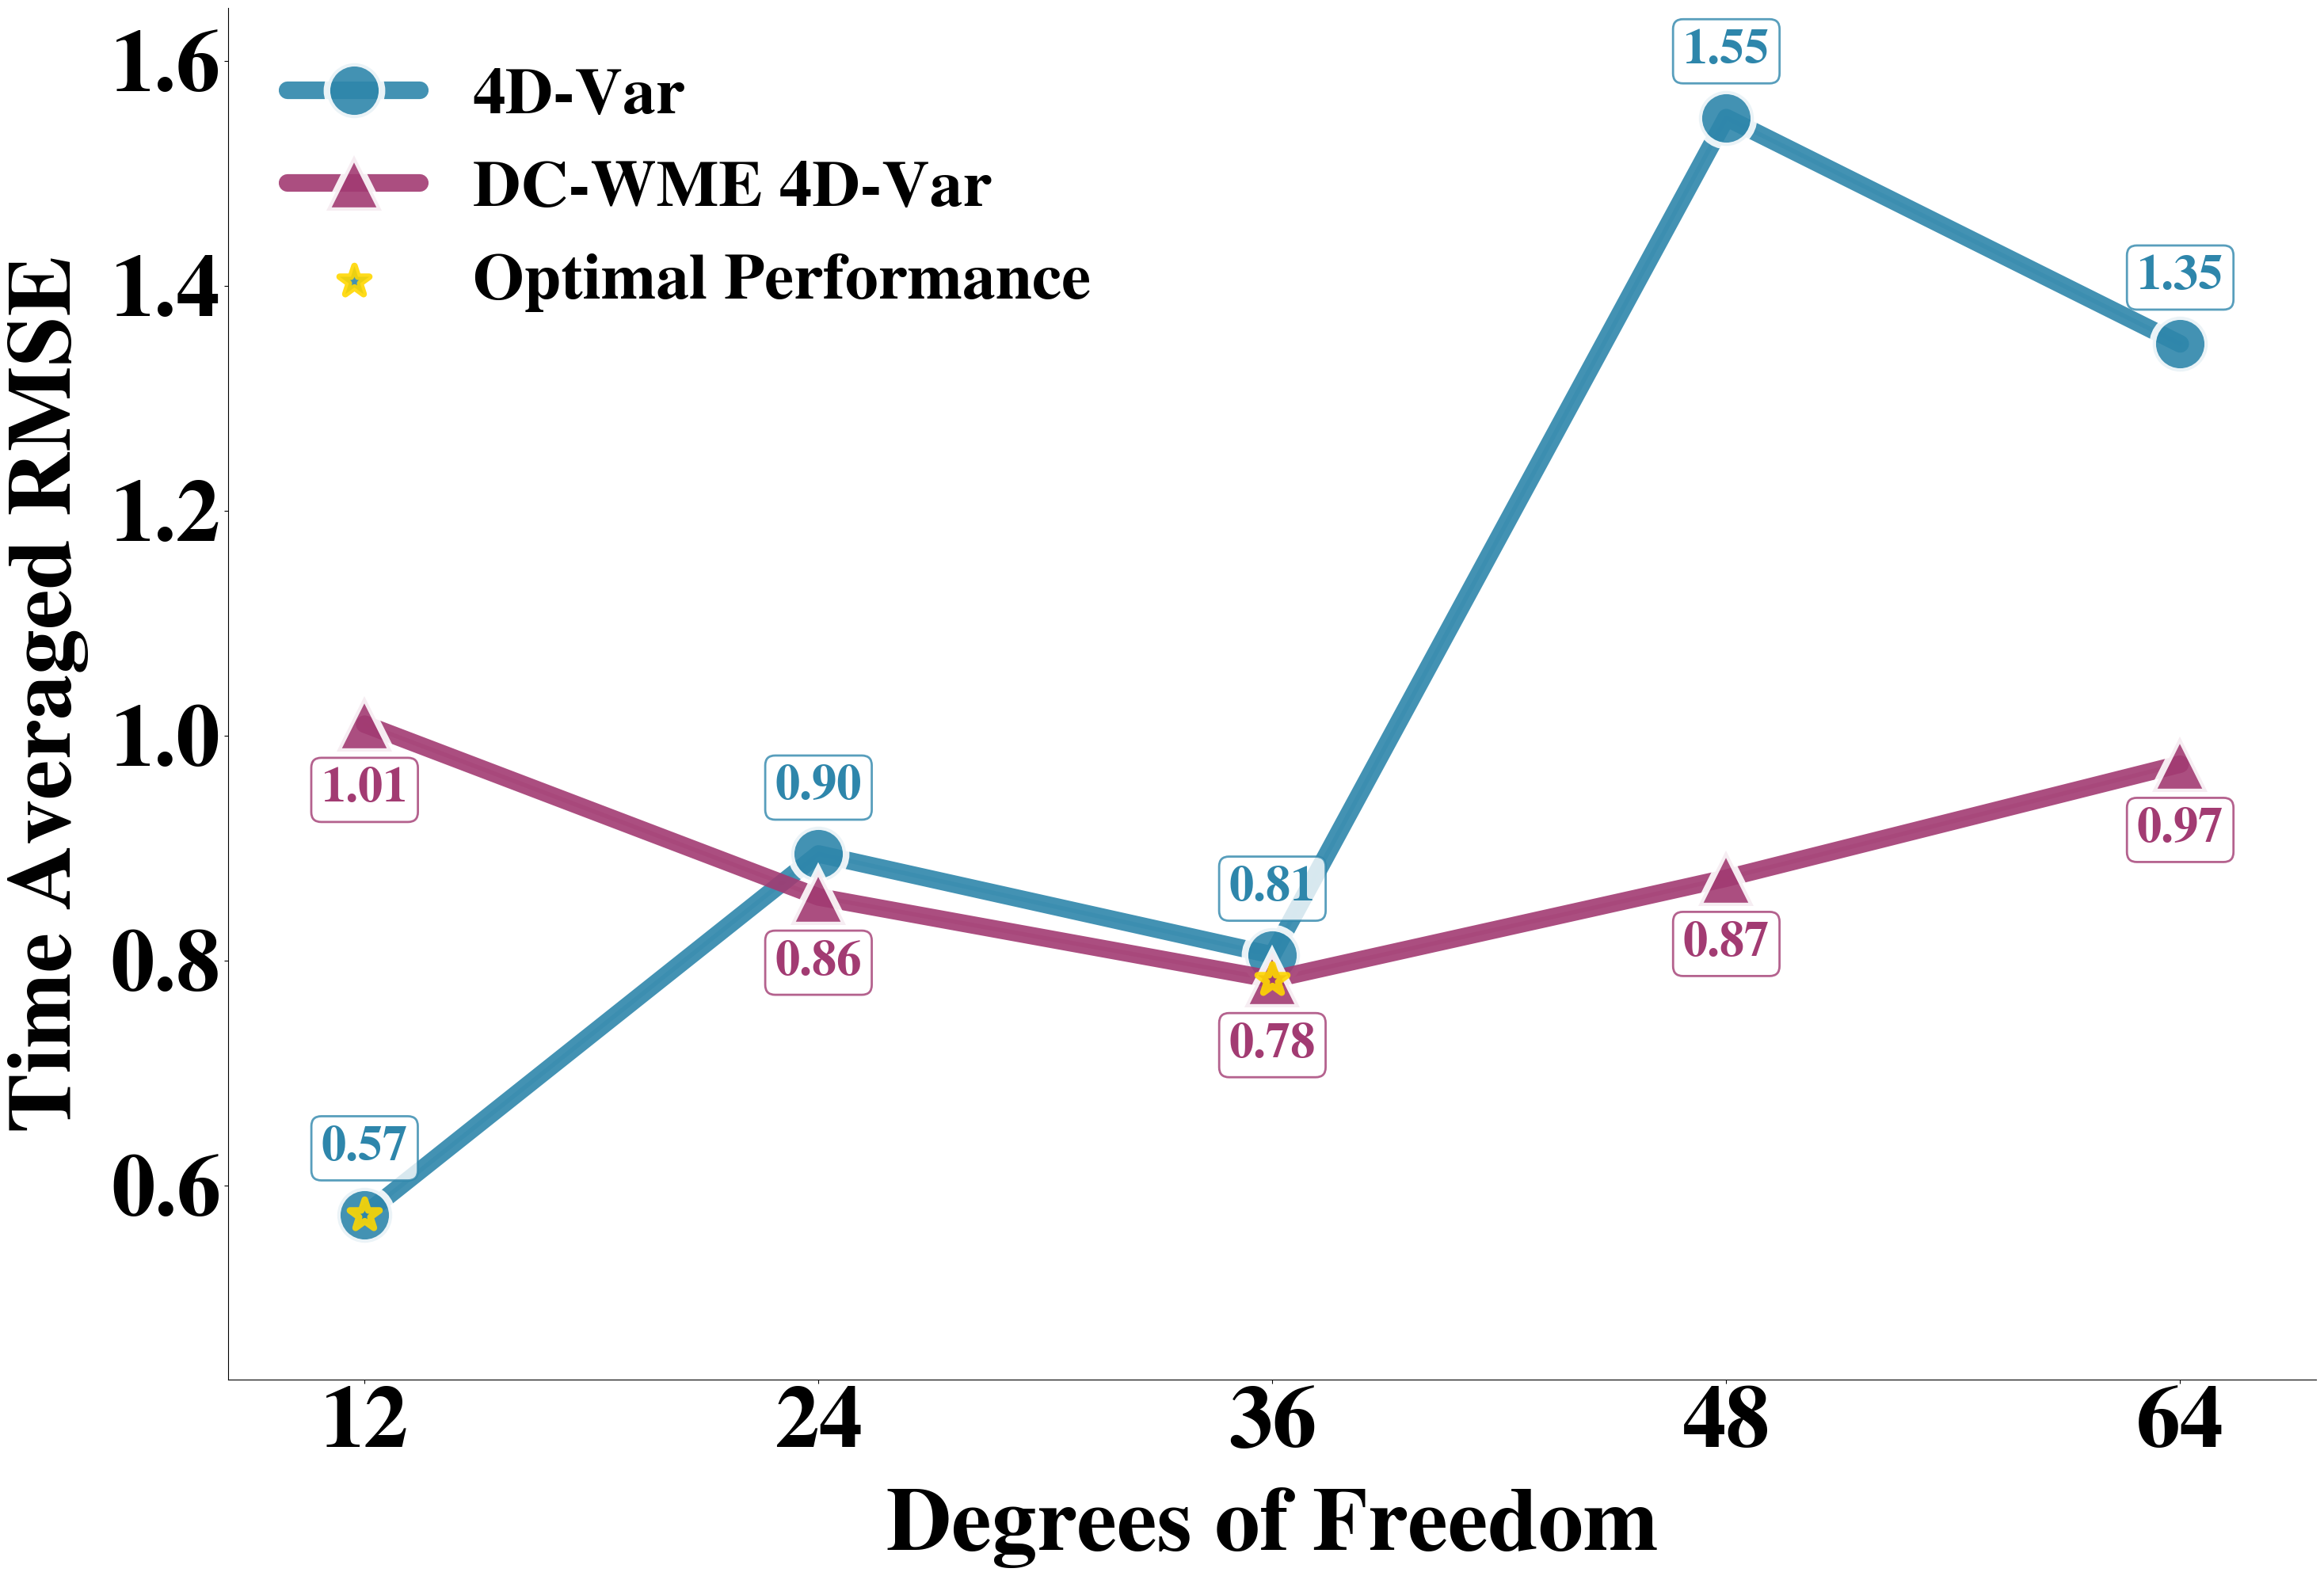

In [37]:





plot_params = {
    "lines.linewidth": 16,
    "lines.markersize": 50,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 60,
    "legend.frameon": False,
    "xtick.labelsize": 80,
    "ytick.labelsize": 80,
    "axes.labelsize": 82,
    "axes.labelpad": 20,
    "axes.titlesize": 50,
    "figure.figsize": (30, 20),
}

# Define colors and styles for each model
colors = {
    '4D-Var': '#2E86AB',
    'DC-WME 4D-Var': '#A23B72'
}


markers = {
    '4D-Var': 'o',
    'DC-WME 4D-Var': '^'
}

model_labels = ['4D-Var', 'DC-WME 4D-Var']

save = True

def create_dof_slope_plot(rmse_dofs, dofs):
    """
    Create a multi-point slope plot for DOF vs RMSE data

    Parameters:
    rmse_dofs: DataFrame with RMSE values, columns [0,2] correspond to the two models
    dofs: list/array of degrees of freedom values
    """

    with plt.rc_context(plot_params):
        fig, ax = plt.subplots(figsize=(30, 20))

        # Extract data for the two models (columns 0 and 2)
        model_data = {
            '4D-Var': rmse_dofs.iloc[:, 0].values,
            'DC-WME 4D-Var': rmse_dofs.iloc[:, 2].values
        }

        # Plot slope lines for each model
        for model_name in model_labels:
            values = model_data[model_name]

            # Plot the main line with markers
            ax.plot(range(len(dofs)), values,
                    marker=markers[model_name],
                    color=colors[model_name],
                    markeredgecolor='white',
                    markeredgewidth=6,
                    alpha=0.9,
                    label=model_name,
                    solid_capstyle='round')

            if model_name == '4D-Var':
                # Add value labels above each point
                for i, (dof, val) in enumerate(zip(dofs, values)):
                    ax.text(i, val + ((values.max() - values.min()) * 0.03)+0.01,
                            f'{val:.2f}',
                            ha='center', va='bottom',
                            fontsize=45,
                            color=colors[model_name],
                            fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.2',
                                    facecolor='white',
                                    alpha=0.8,
                                    edgecolor=colors[model_name],
                                    linewidth=2))
            else:
                for i, (dof, val) in enumerate(zip(dofs, values)):
                    ax.text(i, val + ((values.max() - values.min()) * 0.03)-0.085,
                            f'{val:.2f}',
                            ha='center', va='bottom',
                            fontsize=45,
                            color=colors[model_name],
                            fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.2',
                                    facecolor='white',
                                    alpha=0.8,
                                    edgecolor=colors[model_name],
                                    linewidth=2))


        # Calculate and display performance metrics
        model1_vals = model_data['4D-Var']
        model2_vals = model_data['DC-WME 4D-Var']

        # Find best performing DOF for each model
        # best_dof_model1 = dofs[np.argmin(model1_vals)]
        # best_dof_model2 = dofs[np.argmin(model2_vals)]
        # best_rmse_model1 = model1_vals.min()
        # best_rmse_model2 = model2_vals.min()


        # Customize the plot
        ax.set_xlim(-0.3, len(dofs)-0.7)

        # Set y-axis limits with padding
        all_values = np.concatenate([model1_vals, model2_vals])
        y_min, y_max = all_values.min(), all_values.max()
        y_range = y_max - y_min
        ax.set_ylim(y_min - y_range * 0.15, y_max + y_range * 0.1)

        # Customize x-axis
        ax.set_xticks(range(len(dofs)))
        ax.set_xticklabels([f'{dof}' for dof in dofs], fontweight='bold')

        # Add labels and title
        ax.set_xlabel('Degrees of Freedom', fontweight='bold')
        ax.set_ylabel('Time Averaged RMSE', fontweight='bold')



        # Remove top and right spines
        sns.despine()


        # Add connecting lines between points (subtle)
        for model_name in model_labels:
            values = model_data[model_name]
            ax.plot(range(len(dofs)), values,
                    color=colors[model_name],
                    linewidth=4,
                    alpha=0.3,
                    zorder=0)

        # Highlight the best performance point for each model
        for idx, model_name in enumerate(model_labels):
            values = model_data[model_name]
            best_idx = np.argmin(values)
            if model_name == '4D-Var':
                ax.scatter(best_idx, values[best_idx],
                          s=800,
                          color=colors[model_name],
                          marker='*',
                          edgecolor='gold',
                          linewidth=6,
                          zorder=10,
                          alpha=0.9,
                          label="Optimal Performance"
                          )
            else:
                ax.scatter(best_idx, values[best_idx],
                          s=800,
                          color=colors[model_name],
                          marker='*',
                          edgecolor='gold',
                          linewidth=6,
                          zorder=10,
                          alpha=0.9,
                          )

        # Add legend
        ax.legend(loc='upper left', framealpha=0.9,
                 fancybox=True, shadow=True,
                 )

        plt.tight_layout()

        if save:
            plt.savefig("figures/L96_rmse_dof.png", dpi=300, bbox_inches='tight')

        plt.show()



# Usage examples:
create_dof_slope_plot(rmse_dofs, dofs)  # Multi-point version

____

In [6]:
# Define cost functions
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}



config_96 = Lorenz96Config.default_config(
                                    state_dim=48,
                                    obs_dim=48//2,
                                    total_steps=1000,
                                    window_size=20,
                                    obs_frequency=4,
                                    obs_std=1.2,
                                    inflation_factor=5,
                                    seed=13
                                    )
system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
system_96.obs_system._setup_observation_operator()

results_avg_96 = system_96.run_experiment()
df_avg_96 = pd.DataFrame.from_dict(results_avg_96['results'], orient='index')
df_avg_96

,rmse,relative_error,misfit
Bayes,1.650961,0.329878,16.606234
DCI,2.721968,0.518579,23.046683
DCI_WME,0.730974,0.137036,19.934239


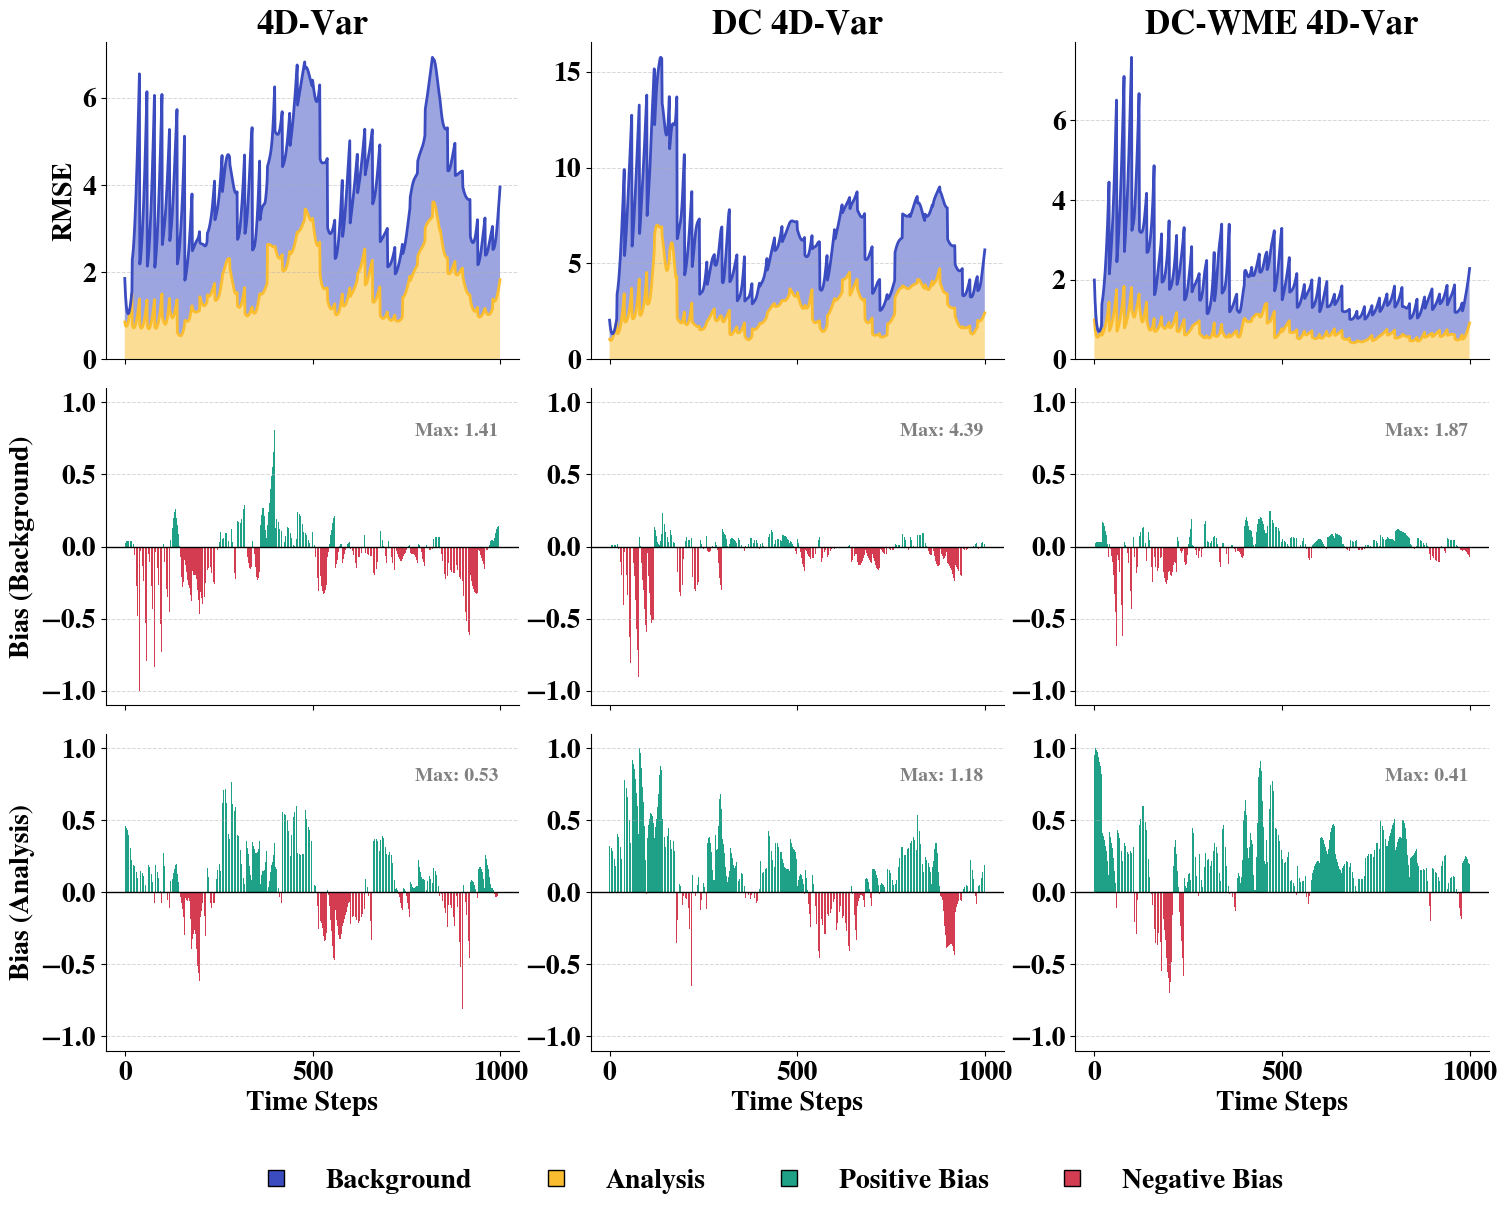

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

sns.set_palette("bright")

# Plot styling parameters
plot_params = {
    "lines.linewidth": 2,
    "lines.markersize": 5,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 20,
    "legend.frameon": False,
    "legend.title_fontsize": "50",
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 25,
    "figure.figsize": (15, 12),
}

# Colors
background_color = "#3B4CC0"  # Indigo
analysis_color   = "#FABD2F"  # Muted yellow-orange
pos_color = "#1FA187"         # Sea Green
neg_color = "#D43D51"         # Scientific red

# Normalization helper
def normalize_series(series):
    max_abs = np.max(np.abs(series))
    if max_abs == 0:
        return series, 1.0
    return series / max_abs, max_abs

models = list(cost_functions.keys())

# Compute scores
rmse_scores_background = {m: rmse(results_avg_96['backgrounds'][m], results_avg_96['trajectory']) for m in models}
bias_scores_background = {m: mbe(results_avg_96['backgrounds'][m], results_avg_96['trajectory']) for m in models}
rmse_scores_analysis = {m: rmse(results_avg_96['analysis'][m], results_avg_96['trajectory']) for m in models}
bias_scores_analysis = {m: mbe(results_avg_96['analysis'][m], results_avg_96['trajectory']) for m in models}

# Convert to DataFrames
rmse_scores_background = pd.DataFrame(rmse_scores_background)
bias_scores_background = pd.DataFrame(bias_scores_background)
rmse_scores_analysis = pd.DataFrame(rmse_scores_analysis)
bias_scores_analysis = pd.DataFrame(bias_scores_analysis)

model_configs = {
    'Bayes': {'title': '4D-Var', 'col': 0},
    'DCI': {'title': 'DC 4D-Var', 'col': 1},
    'DCI_WME': {'title': 'DC-WME 4D-Var', 'col': 2}
}

save = True

with plt.rc_context(plot_params):
    fig, ax = plt.subplots(3, 3, sharex=True)  # 3 rows: RMSE, background bias, analysis bias
    legend_handles = []
    legend_labels = []

    for model, model_config in model_configs.items():
        col = model_config['col']

        # ─── Row 0: RMSE Stacked Area Plot ───────────────
        current_ax = ax[0, col]
        background_rmse = rmse_scores_background[model].values
        analysis_rmse = rmse_scores_analysis[model].values
        x_pos = np.arange(len(background_rmse))

        series = [analysis_rmse, background_rmse]
        colors = [analysis_color, background_color]

        # Stackplot fills
        current_ax.stackplot(
            x_pos,
            series,
            colors=colors,
            alpha=0.5
        )

        # Top edges of each layer for clarity
        cumulative = np.zeros_like(series[0])
        for i, (y, color) in enumerate(zip(series, colors)):
            cumulative += y
            current_ax.plot(
                x_pos, cumulative,
                color=color,
                linewidth=2,
                label='_nolegend_'
            )

        current_ax.set_title(model_config['title'], fontweight='bold')
        if col == 0:
            current_ax.set_ylabel("RMSE", fontweight='bold')
        current_ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.5)
        current_ax.spines['top'].set_visible(False)
        current_ax.spines['right'].set_visible(False)

        # Add legend handles once
        if col == 0:
            legend_handles = [
                plt.Line2D([0], [0], color=background_color, linewidth=0, marker='s', markersize=12, label='Background'),
                plt.Line2D([0], [0], color=analysis_color, linewidth=0, marker='s', markersize=12, label='Analysis'),
                plt.Line2D([0], [0], color=pos_color, linewidth=0, marker='s', markersize=12, label='Positive Bias'),
                plt.Line2D([0], [0], color=neg_color, linewidth=0, marker='s', markersize=12, label='Negative Bias'),
            ]
            legend_labels = ['Background', 'Analysis', 'Positive Bias', 'Negative Bias']

        # ─── Row 1: Normalized Bias for Background ──────────────
        current_ax = ax[1, col]
        signed_bias_bg = bias_scores_background[model]
        normalized_bias, bg_scale = normalize_series(signed_bias_bg)

        for i, val in enumerate(normalized_bias):
            bar_color = pos_color if val >= 0 else neg_color
            current_ax.bar(i, val, color=bar_color, width=0.8)

        current_ax.axhline(0, color='black', linewidth=1.0)
        current_ax.set_ylim(-1.1, 1.1)
        current_ax.text(
            0.95, 0.85, f'Max: {bg_scale:.2f}', transform=current_ax.transAxes,
            ha='right', fontsize=14, color='gray'
        )

        if col == 0:
            current_ax.set_ylabel("Bias (Background)", fontweight='bold')

        current_ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.5)
        current_ax.spines['top'].set_visible(False)
        current_ax.spines['right'].set_visible(False)

        # ─── Row 2: Normalized Bias for Analysis ────────────────
        current_ax = ax[2, col]
        signed_bias_an = bias_scores_analysis[model]
        normalized_bias, an_scale = normalize_series(signed_bias_an)

        for i, val in enumerate(normalized_bias):
            bar_color = pos_color if val >= 0 else neg_color
            current_ax.bar(i, val, color=bar_color, width=0.8)

        current_ax.axhline(0, color='black', linewidth=1.0)
        current_ax.set_ylim(-1.1, 1.1)
        current_ax.text(
            0.95, 0.85, f'Max: {an_scale:.2f}', transform=current_ax.transAxes,
            ha='right', fontsize=14, color='gray'
        )

        current_ax.set_xlabel("Time Steps", fontweight='bold')
        if col == 0:
            current_ax.set_ylabel("Bias (Analysis)", fontweight='bold')

        current_ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.5)
        current_ax.spines['top'].set_visible(False)
        current_ax.spines['right'].set_visible(False)

    # ─── Shared Legend ───────────────────────────────────────
    fig.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=4,
        fontsize=20,
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    if save:
        plt.savefig("figures/combined_rmse_bias_plot_l96.png", bbox_inches='tight')
    plt.show()

___

In [38]:
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}
models = list(cost_functions.keys())
rmse_scores_analysis = {}
window_sizes = [2,5,10]
window_size_dfs = []
rmse_scores_dfs = []

for size in window_sizes:
    config_96 = Lorenz96Config.default_config(
                                    state_dim=48,
                                    obs_dim=48//2,
                                    total_steps=1000,
                                    window_size=size,
                                    obs_frequency=1,
                                    obs_std=1.2,
                                    inflation_factor=5,
                                    seed=13
                                    )
    system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
    system_96.obs_system._setup_observation_operator()
    results_window_96 = system_96.run_experiment()


    for model in models:
        rmse_scores_analysis[model] = rmse(results_window_96['analysis'][model], results_window_96['trajectory'])

    rmse_scores_df = pd.DataFrame(rmse_scores_analysis)
    rmse_scores_dfs.append(rmse_scores_df)
    df = pd.DataFrame.from_dict(results_window_96['results'], orient='index')
    window_size_dfs.append(df)

rmse_window = pd.concat(map(lambda df: df.rmse, window_size_dfs), axis=1)
misfit_window = pd.concat(map(lambda df: df.misfit, window_size_dfs), axis=1)
rel_error_window = pd.concat(map(lambda df: df.relative_error, window_size_dfs), axis=1)
misfit_window.columns = window_sizes
rmse_window.columns = window_sizes
rel_error_window.columns = window_sizes


rmse_4dvar = {size: df['Bayes'].values for size, df in zip(window_sizes, rmse_scores_dfs)}
rmse_dci = {size: df['DCI'].values for size, df in zip(window_sizes, rmse_scores_dfs)}
rmse_dci_wme = {size: df['DCI_WME'].values for size, df in zip(window_sizes, rmse_scores_dfs)}

In [39]:
rmse_scores_dfs[0]

,Bayes,DCI,DCI_WME
0,0.886856,1.022592,0.935053
1,0.840126,1.001576,0.896886
2,0.943943,0.953862,0.889435
3,0.923842,0.931523,0.860247
4,1.030526,1.047514,0.851349
...,...,...,...
995,10.047540,9.956816,9.617880
996,10.041695,9.963156,9.465572
997,10.107803,9.973130,9.525935
998,10.114105,9.993223,9.362130


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Time axis
T = 1000
time = np.arange(T)

# Your specified window sizes
window_sizes = [2, 5, 10]

colors = {
    "4D-Var": "#1192e8",       # IBM Blue
    "DC 4D-Var": "#fa4d56",    # IBM Red
    "DC-WME 4D-Var": "#24a148" # IBM Green
}

# Mixed layout with plots + stacked bar chart (simplified)
def create_mixed_layout_custom(plot_params, save=True):
    """Mixed layout with your data using window sizes 2, 5, and 10 - with stacked bar chart"""

    with plt.rc_context(plot_params):
        fig = plt.figure(figsize=(18, 10))
        gs = gridspec.GridSpec(2, 3, figure=fig)

        # Store line handles and labels for legend
        handles, labels = None, None

        # Three time series plots
        positions = [(0, 0), (0, 1), (1, 0)]

        for idx, w in enumerate(window_sizes):
            ax = fig.add_subplot(gs[positions[idx]])

            # Your original plotting code adapted
            line1, = ax.plot(time, rmse_4dvar[w], label="4D-Var",
                            color=colors["4D-Var"], linestyle='-', linewidth=2.5)
            line2, = ax.plot(time, rmse_dci[w], label="DC 4D-Var",
                            color=colors["DC 4D-Var"], linestyle='--', linewidth=2.5)
            line3, = ax.plot(time, rmse_dci_wme[w], label="DC-WME 4D-Var",
                            color=colors["DC-WME 4D-Var"], linestyle=(0, (3, 1, 1, 1)), linewidth=2.5)

            # Store handles from first plot for legend
            if handles is None and labels is None:
                handles = [line1, line2, line3]
                labels = [line.get_label() for line in handles]

            ax.set_title(f"Window Size = {w}", fontweight='bold')
            ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
            ax.tick_params(axis='both', which='major', pad=8)

            # Your original labeling logic
            if idx >= 0:  # Bottom row (indices 1, 2)
                ax.set_xlabel("Time Steps", fontweight="bold")
            if idx % 2 == 0:  # Left column (indices 0, 2)
                ax.set_ylabel("RMSE", fontweight='bold')

        # Stacked bar chart comparison (mean RMSE) in position (1,1)
        ax_bar = fig.add_subplot(gs[1, 1])

        # Calculate mean RMSE values for each method and window size
        var_means = [np.mean(rmse_4dvar[w]) for w in window_sizes]
        dci_means = [np.mean(rmse_dci[w]) for w in window_sizes]
        dci_wme_means = [np.mean(rmse_dci_wme[w]) for w in window_sizes]

        # Create stacked bars
        x = np.arange(len(window_sizes))
        width = 0.6  # Wider bars for stacked chart

        # Stack the bars - each method stacked on top of the previous
        bars1 = ax_bar.bar(x, var_means, width,
                          label="4D-Var", color=colors["4D-Var"], alpha=0.8,
                          edgecolor='white', linewidth=2)
        bars2 = ax_bar.bar(x, dci_means, width, bottom=var_means,
                          label="DC 4D-Var", color=colors["DC 4D-Var"], alpha=0.8,
                          edgecolor='white', linewidth=2)
        bars3 = ax_bar.bar(x, dci_wme_means, width,
                          bottom=np.array(var_means) + np.array(dci_means),
                          label="DC-WME 4D-Var", color=colors["DC-WME 4D-Var"], alpha=0.8,
                          edgecolor='white', linewidth=2)

        # Add value labels on each segment of the stacked bars
        for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
            # Label for first segment (4D-Var)
            height1 = bar1.get_height()
            ax_bar.text(bar1.get_x() + bar1.get_width()/2., height1/2,
                       f'{var_means[i]:.2f}', ha='center', va='center',
                       fontsize=12, fontweight='bold', color='white')

            # Label for second segment (DC 4D-Var)
            height2 = bar2.get_height()
            y_pos2 = var_means[i] + height2/2
            ax_bar.text(bar2.get_x() + bar2.get_width()/2., y_pos2,
                       f'{dci_means[i]:.2f}', ha='center', va='center',
                       fontsize=12, fontweight='bold', color='white')

            # Label for third segment (DC-WME 4D-Var)
            height3 = bar3.get_height()
            y_pos3 = var_means[i] + dci_means[i] + height3/2
            ax_bar.text(bar3.get_x() + bar3.get_width()/2., y_pos3,
                       f'{dci_wme_means[i]:.2f}', ha='center', va='center',
                       fontsize=12, fontweight='bold', color='white')



        ax_bar.set_xlabel("Window Size", fontweight='bold')
        ax_bar.set_title("Time Averaged RMSE", fontweight='bold')
        ax_bar.set_xticks(x)
        ax_bar.set_xticklabels(window_sizes)
        ax_bar.grid(True, alpha=0.3, axis='y')
        ax_bar.tick_params(axis='both', which='major', pad=8)
        ax_bar.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax_bar.legend(loc='upper right')


        plt.tight_layout(rect=[0, 0, 1, 0.9])

        if save:
            plt.savefig('figures/window_size_plot_l96.png', dpi=300, bbox_inches='tight')

        plt.show()

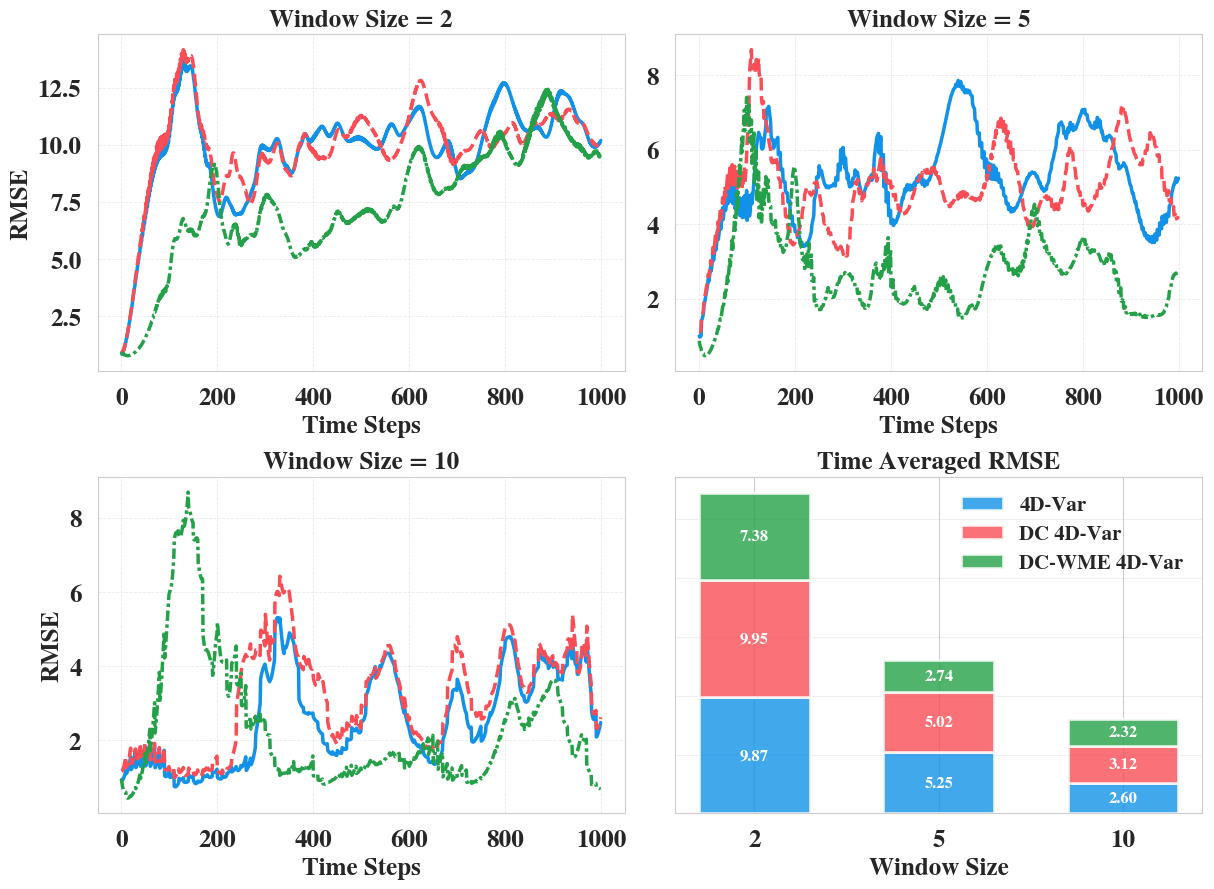

In [62]:
plot_params = {
    "lines.linewidth": 3,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 15,
    "legend.frameon": False,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.labelsize": 18,
    # "axes.labelpad": 10,
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
    "figure.figsize": (18,8),
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'mathtext.default': 'bf',
    'font.family': 'STIXGeneral',
    'font.weight': 'bold',
}
create_mixed_layout_custom(plot_params, save=True)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import uniform_filter1d

# Dummy data setup
T = 1000
time = np.arange(T)
window_sizes = [2, 5, 10]

# Generate synthetic RMSE data
# np.random.seed(0)
# rmse_4dvar = {w: np.abs(np.sin(time / 100 + w) + np.random.normal(0, 0.1, T)) for w in window_sizes}
# rmse_dci = {w: np.abs(np.sin(time / 100 + w + 0.2) + np.random.normal(0, 0.1, T)) for w in window_sizes}
# rmse_dci_wme = {w: np.abs(np.sin(time / 100 + w + 0.4) + np.random.normal(0, 0.1, T)) for w in window_sizes}

colors = {
    "4D-Var": "#1192e8",
    "DC 4D-Var": "#fa4d56",
    "DC-WME 4D-Var": "#24a148"
}

def plot_option_1_heatmap():
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    for idx, w in enumerate(window_sizes):
        ax = fig.add_subplot(gs[(0, idx//2) if idx < 2 else (1, 0)])
        data = np.stack([rmse_4dvar[w], rmse_dci[w], rmse_dci_wme[w]], axis=0)
        im = ax.imshow(data, aspect='auto', cmap='viridis', extent=[0, T, 0, 3])
        ax.set_yticks([0.5, 1.5, 2.5])
        ax.set_yticklabels(["4D-Var", "DC 4D-Var", "DC-WME"])
        ax.set_title(f"Heatmap – Window Size = {w}")
    fig.colorbar(im, ax=fig.get_axes(), orientation='horizontal', fraction=0.02, pad=0.04)
    return fig

def plot_option_2_stacked_area():
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    for idx, w in enumerate(window_sizes):
        ax = fig.add_subplot(gs[(0, idx//2) if idx < 2 else (1, 0)])
        ax.stackplot(time, rmse_4dvar[w], rmse_dci[w], rmse_dci_wme[w],
                     labels=["4D-Var", "DC 4D-Var", "DC-WME"],
                     colors=[colors["4D-Var"], colors["DC 4D-Var"], colors["DC-WME 4D-Var"]],
                     alpha=0.8)
        ax.set_title(f"Stacked Area – Window Size = {w}")
        ax.set_xlabel("Time")
        ax.set_ylabel("RMSE")
    return fig

def plot_option_3_dot_raster():
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    for idx, w in enumerate(window_sizes):
        ax = fig.add_subplot(gs[(0, idx//2) if idx < 2 else (1, 0)])
        t_ds = time[::10]
        ax.scatter(t_ds, rmse_4dvar[w][::10], s=10, color=colors["4D-Var"], alpha=0.5, label="4D-Var")
        ax.scatter(t_ds, rmse_dci[w][::10], s=10, color=colors["DC 4D-Var"], alpha=0.5, label="DC")
        ax.scatter(t_ds, rmse_dci_wme[w][::10], s=10, color=colors["DC-WME 4D-Var"], alpha=0.5, label="DC-WME")
        ax.set_title(f"Dot Plot – Window Size = {w}")
        ax.set_xlabel("Time")
        ax.set_ylabel("RMSE")
    return fig

def plot_option_4_delta():
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    for idx, w in enumerate(window_sizes):
        ax = fig.add_subplot(gs[(0, idx//2) if idx < 2 else (1, 0)])
        delta_dci = rmse_dci[w] - rmse_4dvar[w]
        delta_wme = rmse_dci_wme[w] - rmse_4dvar[w]
        ax.plot(time, delta_dci, label="DC - 4DVar", color=colors["DC 4D-Var"])
        ax.plot(time, delta_wme, label="DC-WME - 4DVar", color=colors["DC-WME 4D-Var"])
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_title(f"Delta – Window Size = {w}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Δ RMSE")
    return fig

def plot_option_6_segment_bar():
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    for idx, w in enumerate(window_sizes):
        ax = fig.add_subplot(gs[(0, idx//2) if idx < 2 else (1, 0)])
        chunk_size = 100
        n_chunks = T // chunk_size
        chunks = np.array_split(rmse_4dvar[w], n_chunks)
        means = [np.mean(c) for c in chunks]
        ax.bar(np.arange(n_chunks), means, width=0.8, color=colors["4D-Var"])
        ax.set_title(f"Segmented RMSE – Window Size = {w}")
        ax.set_xlabel("Segment")
        ax.set_ylabel("Avg RMSE")
    return fig



# Run and display all figures
figs = [
    plot_option_1_heatmap(),
    plot_option_2_stacked_area(),
    plot_option_3_dot_raster(),
    plot_option_4_delta(),
    plot_option_6_segment_bar()
]
for fig in figs:
    fig.tight_layout()
    fig.show()



/var/folders/14/4_5vrl2912bc84l063zdm5l80000gq/T/ipykernel_75929/2845201112.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/14/4_5vrl2912bc84l063zdm5l80000gq/T/ipykernel_75929/2845201112.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


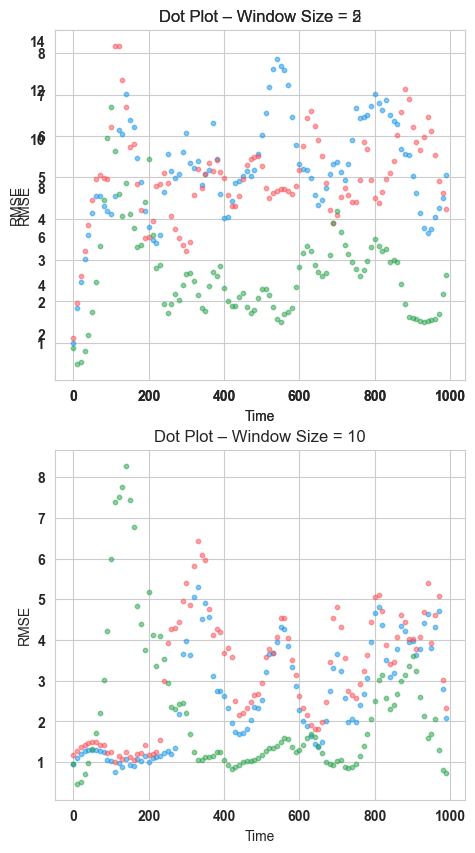

In [70]:
plot_option_3_dot_raster()

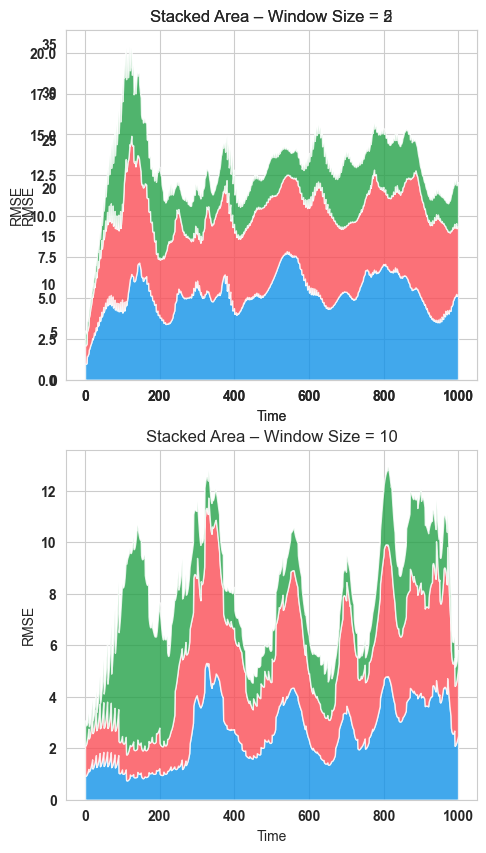

In [69]:
plot_option_2_stacked_area()

In [50]:


# Enhanced with Statistical Information
def create_timeseries_enhanced_stats(rmse_data, window_sizes, time, colors, save=True):
    """Enhanced version with rolling averages, confidence intervals, and summary stats"""
    
    methods = ["4D-Var", "DC 4D-Var", "DC-WME 4D-Var"]
    line_styles = ['-', '--', (0, (3, 1, 1, 1))]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Top row: Original time series with rolling averages
    for idx, window_size in enumerate(window_sizes):
        ax = axes[0, idx]
        
        for method_idx, (method, style) in enumerate(zip(methods, line_styles)):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            
            # Original line
            ax.plot(time, data, label=f"{method}", 
                   color=colors[method], linestyle=style, linewidth=1.5, alpha=0.7)
            
            # Rolling average (smoothed)
            window = 50  # Rolling window
            rolling_mean = pd.Series(data).rolling(window=window, center=True).mean()
            ax.plot(time, rolling_mean, color=colors[method], linewidth=3, alpha=0.9)
        
        ax.set_title(f"Window Size = {window_size} (with Rolling Avg)", fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("RMSE" if idx == 0 else "")
    
    # Bottom row: Distribution comparisons
    for idx, window_size in enumerate(window_sizes):
        ax = axes[1, idx]
        
        data_for_violin = []
        labels_for_violin = []
        
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            data_for_violin.append(data)
            labels_for_violin.append(method)
        
        # Violin plot for distribution comparison
        parts = ax.violinplot(data_for_violin, positions=range(len(methods)), 
                             showmeans=True, showmedians=True)
        
        # Color the violin plots
        for pc, method in zip(parts['bodies'], methods):
            pc.set_facecolor(colors[method])
            pc.set_alpha(0.7)
        
        ax.set_title(f"RMSE Distributions (Window = {window_size})", fontweight='bold')
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45)
        ax.set_ylabel("RMSE" if idx == 0 else "")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig('timeseries_enhanced_stats.png', dpi=300, bbox_inches='tight')
    plt.show()


# APPROACH 4: Subplot Function with Customizable Features
def plot_single_timeseries(ax, rmse_data, window_size, time, colors, methods, 
                          line_styles, show_legend=False, highlight_periods=None):
    """Reusable function for plotting a single time series subplot"""
    
    lines = []
    for method_idx, (method, style) in enumerate(zip(methods, line_styles)):
        data_key = list(rmse_data.keys())[method_idx]
        line = ax.plot(time, rmse_data[data_key][window_size], 
                      label=method, color=colors[method], 
                      linestyle=style, linewidth=2.5, alpha=0.9)[0]
        lines.append(line)
    
    # Optional: Highlight specific time periods
    if highlight_periods:
        for start, end, color, alpha in highlight_periods:
            ax.axvspan(start, end, color=color, alpha=alpha, zorder=0)
    
    # Styling
    ax.set_title(f"Window Size = {window_size}", fontweight='bold', pad=15)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Optional statistics annotation
    mean_vals = []
    for method_idx, method in enumerate(methods):
        data_key = list(rmse_data.keys())[method_idx]
        mean_val = np.mean(rmse_data[data_key][window_size])
        mean_vals.append(f"{method}: {mean_val:.3f}")
    
    # Add text box with statistics
    stats_text = "Means:\n" + "\n".join(mean_vals)
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    if show_legend:
        ax.legend(loc='upper right')
    
    return lines

def create_timeseries_modular(rmse_data, window_sizes, time, colors, save=True):
    """Modular approach using reusable subplot function"""
    
    methods = ["4D-Var", "DC 4D-Var", "DC-WME 4D-Var"]
    line_styles = ['-', '--', (0, (3, 1, 1, 1))]
    
    # Define some periods to highlight (example: model spin-up, steady state, etc.)
    highlight_periods = [(0, 100, 'yellow', 0.2), (800, 1000, 'lightblue', 0.2)]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    legend_lines = None
    for idx, (ax, window_size) in enumerate(zip(axes, window_sizes)):
        lines = plot_single_timeseries(ax, rmse_data, window_size, time, colors, 
                                     methods, line_styles, show_legend=False,
                                     highlight_periods=highlight_periods)
        
        # Set axis labels
        ax.set_xlabel("Time Steps", fontweight='bold')
        if idx == 0:
            ax.set_ylabel("RMSE", fontweight='bold')
            legend_lines = lines  # Store for unified legend
    
    # Unified legend
    if legend_lines:
        fig.legend(legend_lines, methods, loc='upper center', 
                  bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=True)
    
    plt.tight_layout()
    if save:
        plt.savefig('timeseries_modular.png', dpi=300, bbox_inches='tight')
    plt.show()



In [56]:
rmse_data = {
    'rmse_4dvar': rmse_4dvar,
    'rmse_dci': rmse_dci,
    'rmse_dci_wme': rmse_dci_wme
}

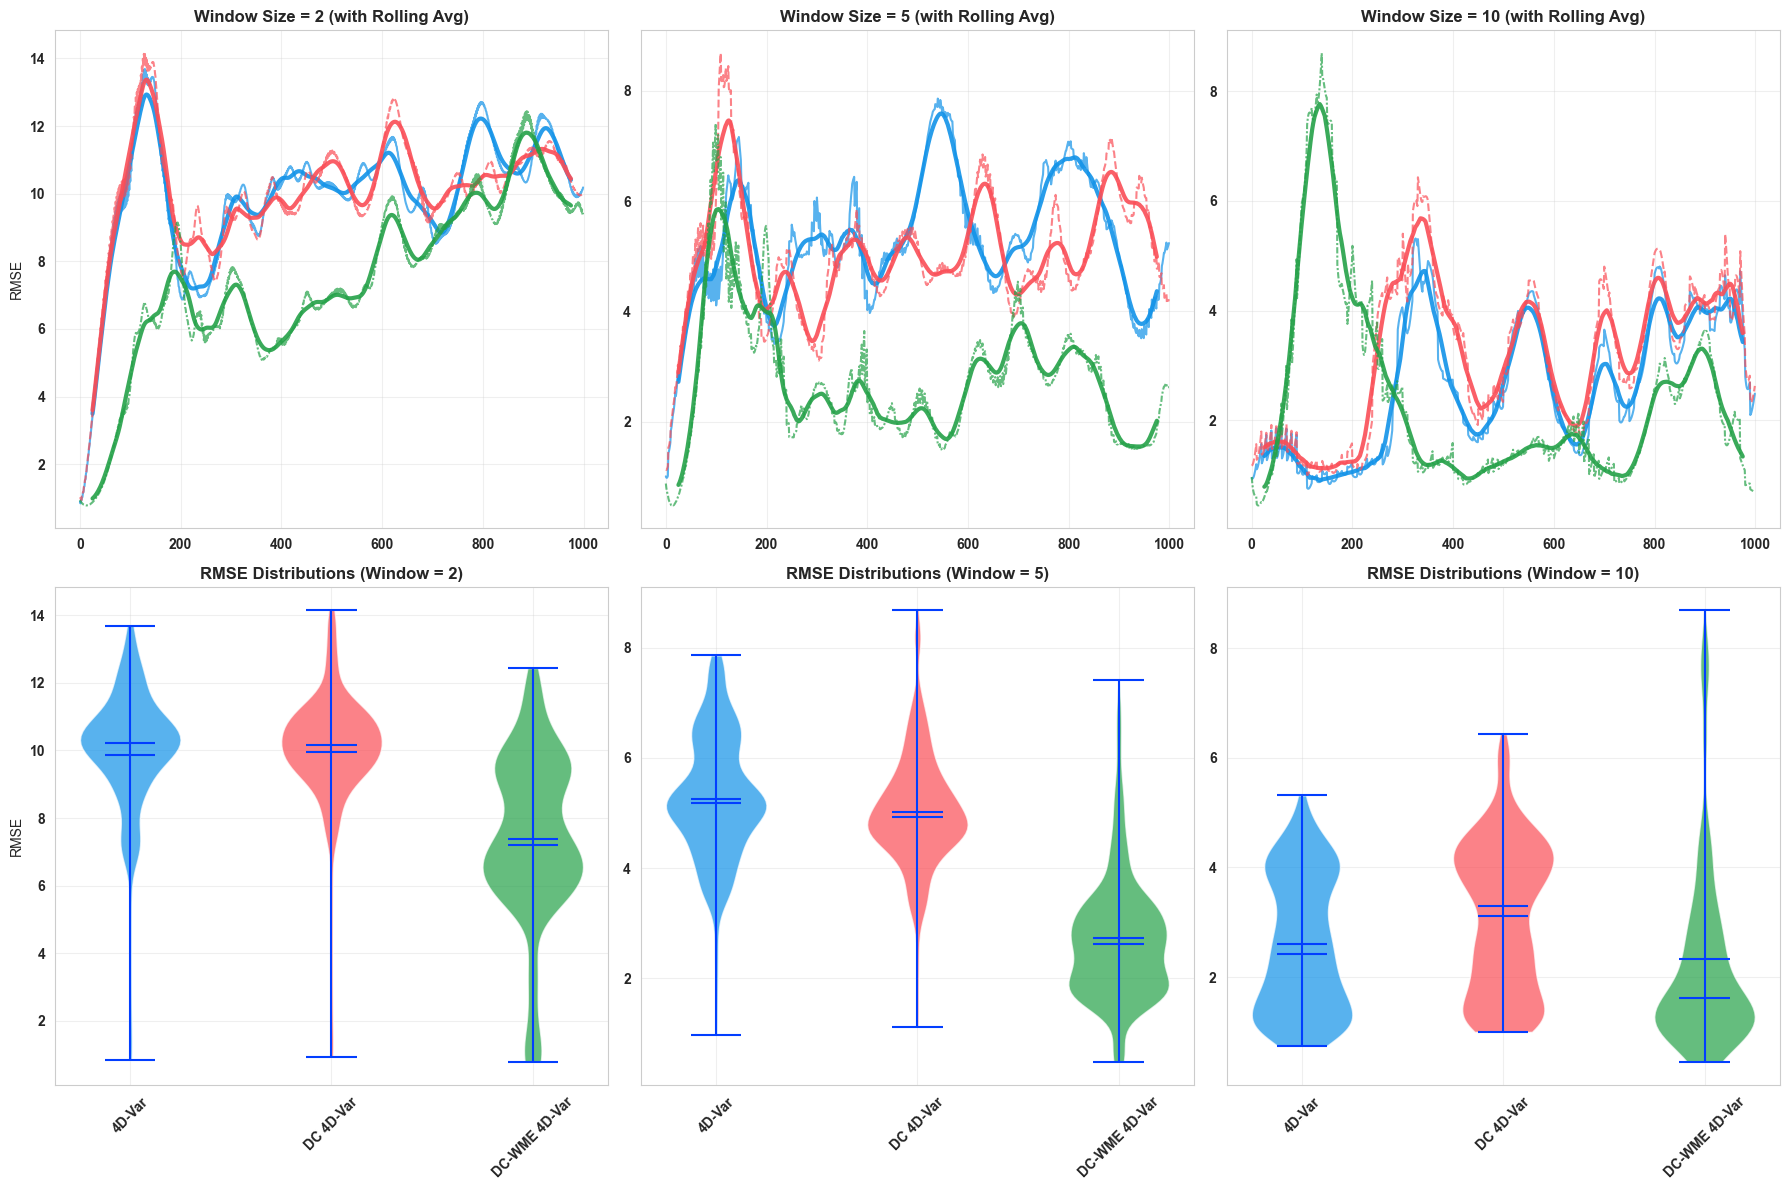

In [ ]:

create_timeseries_enhanced_stats(rmse_data, window_sizes, time, colors)


Creating alternative time series visualizations...


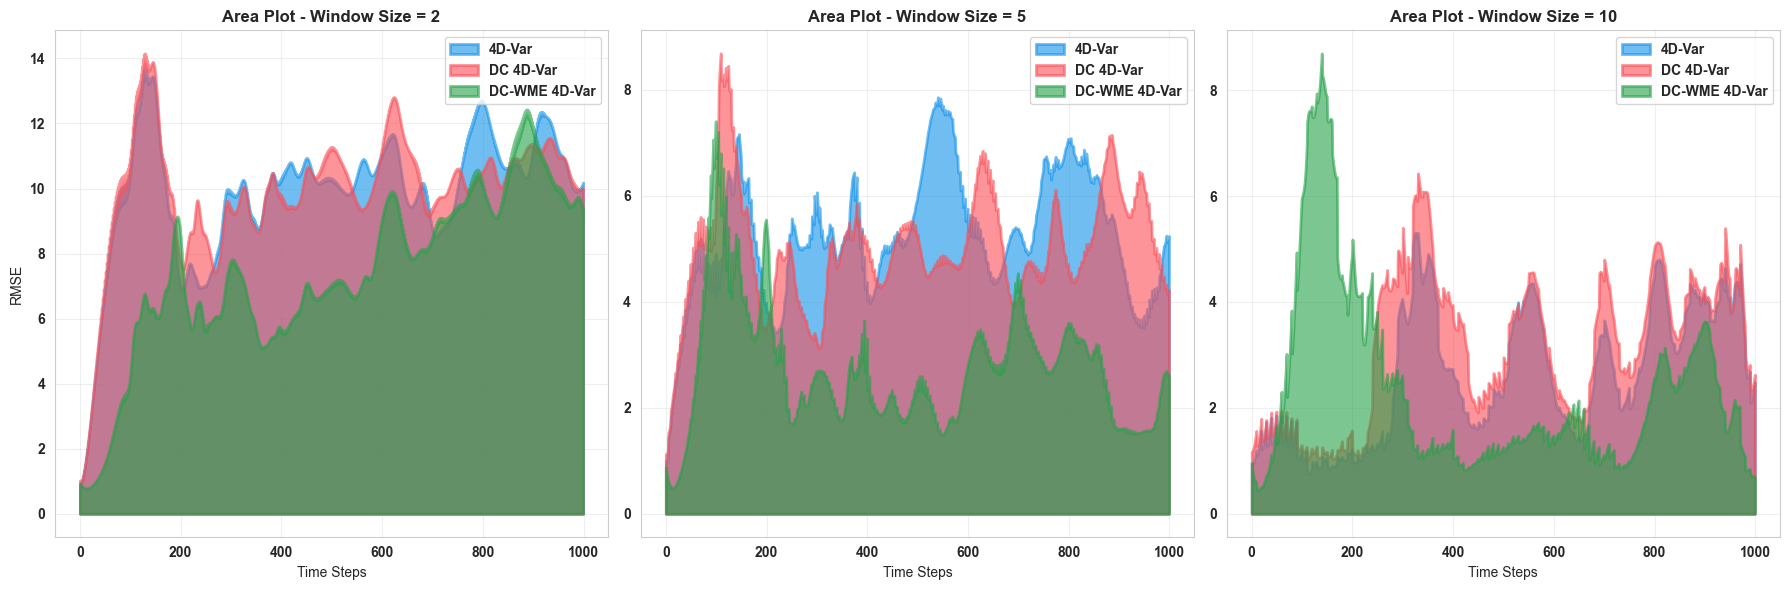

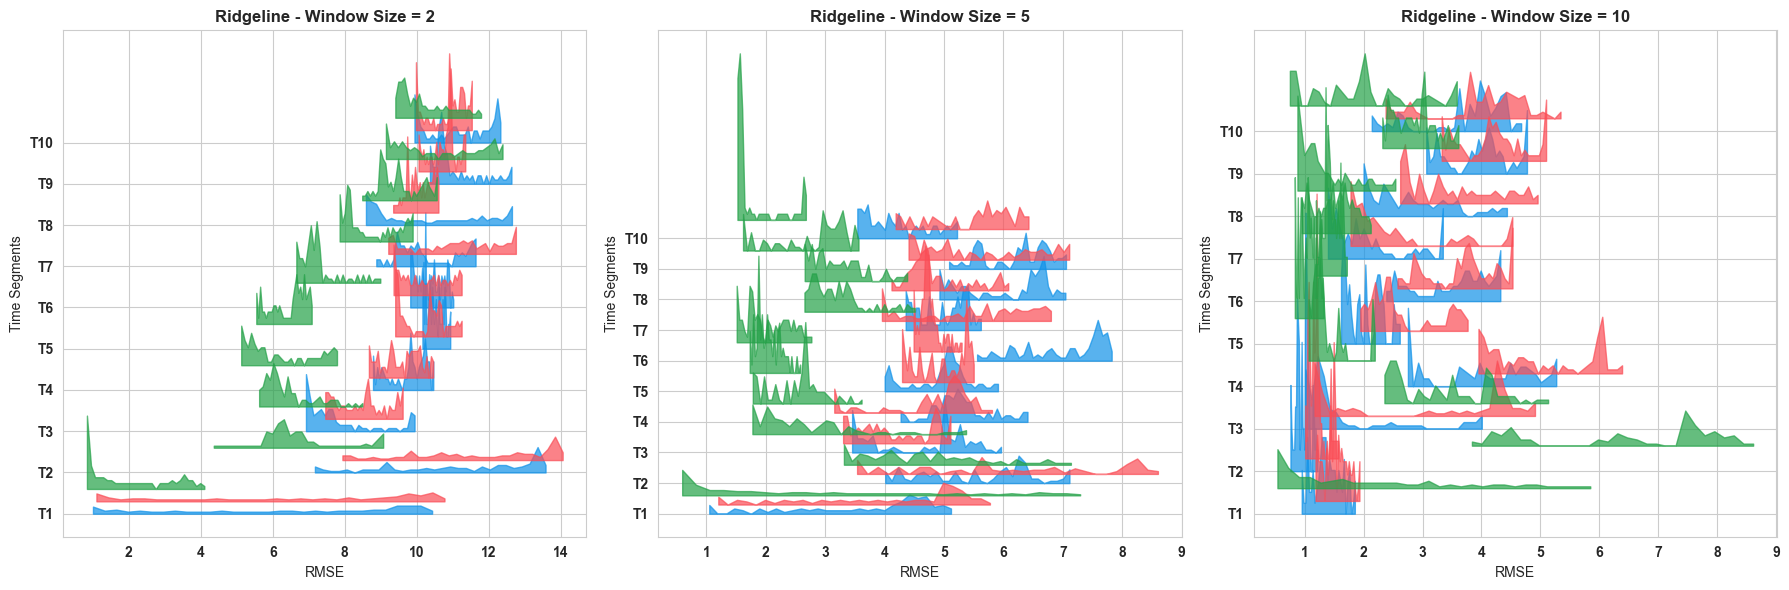

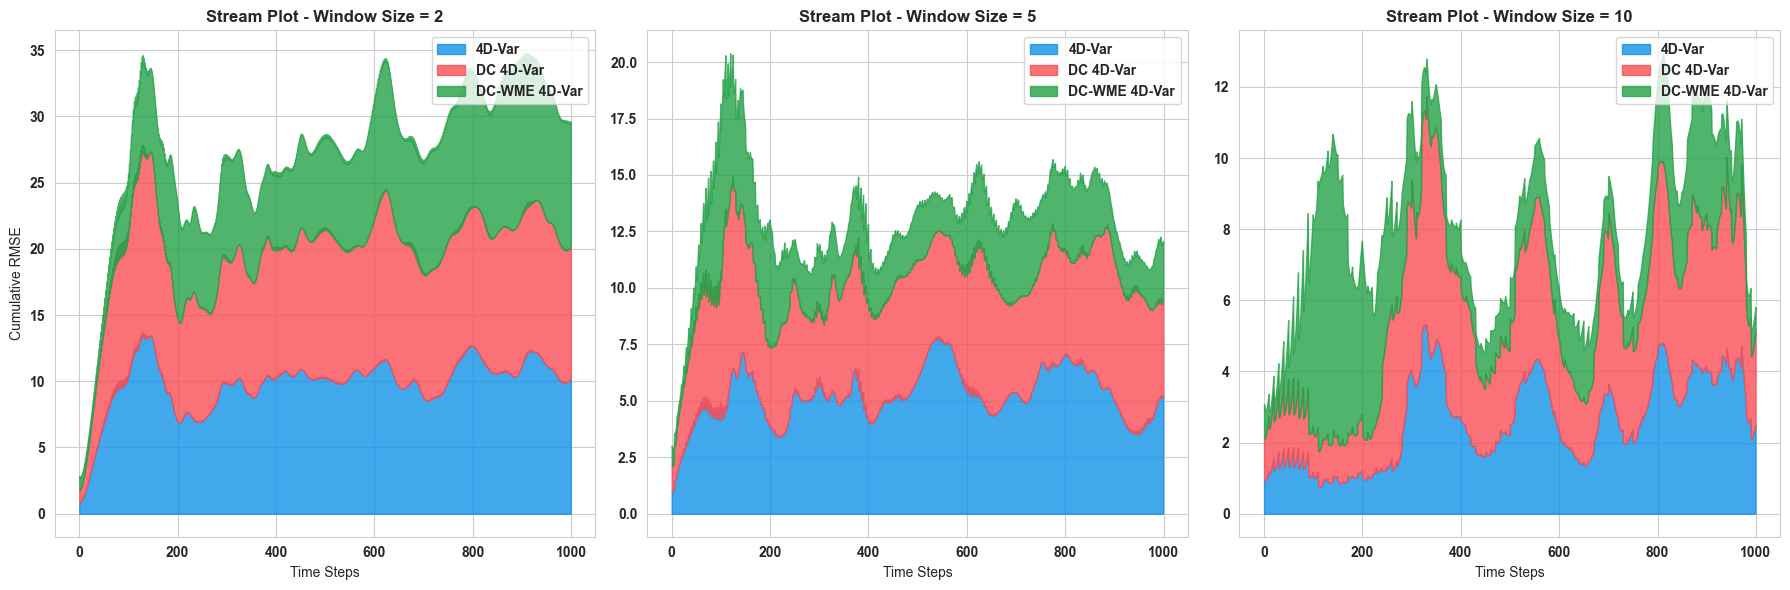

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# # Generate sample data structure
# def generate_sample_data():
#     """Generate sample RMSE data for demonstration"""
#     T = 1000
#     window_sizes = [2, 5, 10]
    
#     # Simulate realistic RMSE data with some trends
#     np.random.seed(42)
#     rmse_data = {}
    
#     for i, method_key in enumerate(['rmse_4dvar', 'rmse_dci', 'rmse_dci_wme']):
#         rmse_data[method_key] = {}
#         for w in window_sizes:
#             # Create realistic RMSE patterns with different characteristics
#             base_trend = 0.5 + 0.3 * np.sin(np.linspace(0, 4*np.pi, T)) + i*0.1
#             noise = np.random.normal(0, 0.1, T)
#             rmse_data[method_key][w] = np.maximum(0.1, base_trend + noise + w*0.05)
    
#     return rmse_data, window_sizes, np.arange(T)

# rmse_data, window_sizes, time = generate_sample_data()

colors = {
    "4D-Var": "#1192e8",
    "DC 4D-Var": "#fa4d56", 
    "DC-WME 4D-Var": "#24a148"
}
methods = ["4D-Var", "DC 4D-Var", "DC-WME 4D-Var"]

# 1. AREA/FILLED PLOTS
def create_area_plots(rmse_data, window_sizes, time, colors, save=True):
    """Area plots showing magnitude and allowing stacking"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, window_size in enumerate(window_sizes):
        ax = axes[idx]
        
        # Option A: Separate filled areas
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            
            ax.fill_between(time, 0, data, alpha=0.6, color=colors[method], 
                           label=method, linewidth=2, edgecolor=colors[method])
        
        ax.set_title(f"Area Plot - Window Size = {window_size}", fontweight='bold')
        ax.set_xlabel("Time Steps")
        if idx == 0:
            ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    if save:
        plt.savefig('area_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. HEATMAP REPRESENTATION
def create_heatmap_plots(rmse_data, window_sizes, time, save=True):
    """Heatmap showing time vs methods with RMSE as color intensity"""
    fig, axes = plt.subplots(3, 1, figsize=(18, 12))
    
    for idx, window_size in enumerate(window_sizes):
        # Prepare data matrix: methods x time
        data_matrix = []
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data_matrix.append(rmse_data[data_key][window_size])
        
        data_matrix = np.array(data_matrix)
        
        # Create heatmap
        im = axes[idx].imshow(data_matrix, aspect='auto', cmap='viridis', 
                             extent=[0, len(time), 0, len(methods)])
        
        axes[idx].set_title(f"Heatmap - Window Size = {window_size}", fontweight='bold')
        axes[idx].set_xlabel("Time Steps")
        axes[idx].set_ylabel("Methods")
        axes[idx].set_yticks(np.arange(len(methods)) + 0.5)
        axes[idx].set_yticklabels(methods)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[idx], label='RMSE')
    
    plt.tight_layout()
    if save:
        plt.savefig('heatmap_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. RIDGELINE/JOY PLOTS
def create_ridgeline_plots(rmse_data, window_sizes, time, colors, save=True):
    """Ridgeline plots showing distributions over time windows"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for plot_idx, window_size in enumerate(window_sizes):
        ax = axes[plot_idx]
        
        # Divide time into segments for distribution analysis
        n_segments = 10
        segment_size = len(time) // n_segments
        
        y_positions = np.arange(n_segments)
        
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            
            for seg_idx in range(n_segments):
                start_idx = seg_idx * segment_size
                end_idx = (seg_idx + 1) * segment_size
                segment_data = data[start_idx:end_idx]
                
                # Create distribution curve
                hist, bin_edges = np.histogram(segment_data, bins=30, density=True)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                
                # Scale and position the distribution
                scaled_hist = hist * 0.8 + seg_idx + method_idx * 0.3
                
                ax.fill_between(bin_centers, seg_idx + method_idx * 0.3, scaled_hist, 
                               alpha=0.7, color=colors[method])
        
        ax.set_title(f"Ridgeline - Window Size = {window_size}", fontweight='bold')
        ax.set_xlabel("RMSE")
        ax.set_ylabel("Time Segments")
        ax.set_yticks(y_positions)
        ax.set_yticklabels([f"T{i+1}" for i in range(n_segments)])
    
    plt.tight_layout()
    if save:
        plt.savefig('ridgeline_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. STREAM/RIVER PLOTS
def create_stream_plots(rmse_data, window_sizes, time, colors, save=True):
    """Stream graphs showing flowing data"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, window_size in enumerate(window_sizes):
        ax = axes[idx]
        
        # Prepare stacked data
        data_arrays = []
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data_arrays.append(np.array(rmse_data[data_key][window_size], dtype=float))
        
        # Create stacked areas with smooth curves
        y_bottom = np.zeros_like(time, dtype=float)  # Fix: Ensure float dtype
        
        for method_idx, (method, data) in enumerate(zip(methods, data_arrays)):
            ax.fill_between(time, y_bottom, y_bottom + data, 
                           alpha=0.8, color=colors[method], label=method)
            y_bottom += data
        
        ax.set_title(f"Stream Plot - Window Size = {window_size}", fontweight='bold')
        ax.set_xlabel("Time Steps")
        if idx == 0:
            ax.set_ylabel("Cumulative RMSE")
        ax.legend()
    
    plt.tight_layout()
    if save:
        plt.savefig('stream_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 5. DIFFERENCE/RATIO PLOTS
def create_difference_plots(rmse_data, window_sizes, time, colors, save=True):
    """Show relative performance differences"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for idx, window_size in enumerate(window_sizes):
        # Get baseline (first method)
        baseline_data = rmse_data[list(rmse_data.keys())[0]][window_size]
        
        # Top row: Absolute differences
        ax1 = axes[0, idx]
        for method_idx, method in enumerate(methods[1:], 1):  # Skip baseline
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            difference = data - baseline_data
            
            ax1.plot(time, difference, label=f"{method} - {methods[0]}", 
                    color=colors[method], linewidth=2)
        
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax1.set_title(f"Differences from {methods[0]} - Window {window_size}", fontweight='bold')
        ax1.set_ylabel("RMSE Difference")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Bottom row: Percentage differences
        ax2 = axes[1, idx]
        for method_idx, method in enumerate(methods[1:], 1):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            pct_diff = ((data - baseline_data) / baseline_data) * 100
            
            ax2.plot(time, pct_diff, label=f"{method} vs {methods[0]}", 
                    color=colors[method], linewidth=2)
        
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title(f"% Difference from {methods[0]} - Window {window_size}", fontweight='bold')
        ax2.set_xlabel("Time Steps")
        ax2.set_ylabel("% Difference")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig('difference_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 6. CANDLESTICK-STYLE PLOTS
def create_candlestick_style_plots(rmse_data, window_sizes, time, colors, save=True):
    """Candlestick-style showing high/low/mean for time periods"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define time windows for aggregation
    window_length = 50
    n_windows = len(time) // window_length
    
    for idx, window_size in enumerate(window_sizes):
        ax = axes[idx]
        
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            
            x_positions = []
            means, highs, lows = [], [], []
            
            for w in range(n_windows):
                start_idx = w * window_length
                end_idx = (w + 1) * window_length
                segment = data[start_idx:end_idx]
                
                x_positions.append(start_idx + window_length/2)
                means.append(np.mean(segment))
                highs.append(np.max(segment))
                lows.append(np.min(segment))
            
            # Plot high-low lines
            for x, low, high, mean in zip(x_positions, lows, highs, means):
                ax.plot([x + method_idx*5, x + method_idx*5], [low, high], 
                       color=colors[method], linewidth=3, alpha=0.7)
                ax.plot(x + method_idx*5, mean, 'o', color=colors[method], 
                       markersize=8, label=method if x == x_positions[0] else "")
        
        ax.set_title(f"High-Low-Mean - Window Size = {window_size}", fontweight='bold')
        ax.set_xlabel("Time Steps")
        if idx == 0:
            ax.set_ylabel("RMSE")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig('candlestick_style_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 7. POLAR/CIRCULAR TIME SERIES
def create_polar_plots(rmse_data, window_sizes, colors, save=True):
    """Circular/polar representation of time series"""
    fig = plt.figure(figsize=(18, 6))
    
    for idx, window_size in enumerate(window_sizes):
        ax = fig.add_subplot(1, 3, idx+1, projection='polar')
        
        # Convert time to angles (0 to 2π)
        angles = np.linspace(0, 2*np.pi, len(time), endpoint=False)
        
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data = rmse_data[data_key][window_size]
            
            ax.plot(angles, data, color=colors[method], linewidth=2, 
                   label=method, alpha=0.8)
        
        ax.set_title(f"Polar View - Window Size = {window_size}", 
                    fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
    
    plt.tight_layout()
    if save:
        plt.savefig('polar_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. SMALL MULTIPLES/SPARKLINES
def create_small_multiples(rmse_data, window_sizes, time, colors, save=True):
    """Many small charts showing detailed patterns"""
    n_segments = 6
    segment_length = len(time) // n_segments
    
    fig, axes = plt.subplots(n_segments, 3, figsize=(18, 15))
    
    for col_idx, window_size in enumerate(window_sizes):
        for seg_idx in range(n_segments):
            ax = axes[seg_idx, col_idx]
            
            start_idx = seg_idx * segment_length
            end_idx = (seg_idx + 1) * segment_length
            time_segment = time[start_idx:end_idx]
            
            for method_idx, method in enumerate(methods):
                data_key = list(rmse_data.keys())[method_idx]
                data_segment = rmse_data[data_key][window_size][start_idx:end_idx]
                
                ax.plot(time_segment, data_segment, color=colors[method], 
                       linewidth=2, alpha=0.8)
            
            # Minimal styling for sparkline effect
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            if seg_idx == 0:
                ax.set_title(f"Window {window_size}", fontweight='bold')
            if col_idx == 0:
                ax.set_ylabel(f"Seg {seg_idx+1}", rotation=0, ha='right')
            
            # Add mean line
            for method_idx, method in enumerate(methods):
                data_key = list(rmse_data.keys())[method_idx]
                data_segment = rmse_data[data_key][window_size][start_idx:end_idx]
                mean_val = np.mean(data_segment)
                ax.axhline(y=mean_val, color=colors[method], 
                          linestyle='--', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    if save:
        plt.savefig('small_multiples.png', dpi=300, bbox_inches='tight')
    plt.show()

# 9. 3D SURFACE PLOTS
def create_3d_surface_plots(rmse_data, window_sizes, time, save=True):
    """3D surface representation"""
    fig = plt.figure(figsize=(20, 6))
    
    for idx, window_size in enumerate(window_sizes):
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        
        # Create meshgrid with proper float dtypes
        time_sub = time[::10].astype(float)
        T, M = np.meshgrid(time_sub, np.arange(len(methods), dtype=float))
        
        # Prepare Z data
        Z = np.zeros_like(T, dtype=float)
        for method_idx in range(len(methods)):
            data_key = list(rmse_data.keys())[method_idx]
            Z[method_idx, :] = np.array(rmse_data[data_key][window_size][::10], dtype=float)
        
        # Create surface
        surf = ax.plot_surface(T, M, Z, cmap='viridis', alpha=0.8)
        
        ax.set_title(f"3D Surface - Window Size = {window_size}", fontweight='bold')
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Method Index")
        ax.set_zlabel("RMSE")
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels(methods)
        
        plt.colorbar(surf, ax=ax, shrink=0.5)
    
    plt.tight_layout()
    if save:
        plt.savefig('3d_surface_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# 10. CONTOUR PLOTS
def create_contour_plots(rmse_data, window_sizes, time, save=True):
    """Contour plots showing isolines of RMSE values"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, window_size in enumerate(window_sizes):
        ax = axes[idx]
        
        # Create data matrix for contour
        data_matrix = []
        for method_idx, method in enumerate(methods):
            data_key = list(rmse_data.keys())[method_idx]
            data_matrix.append(np.array(rmse_data[data_key][window_size], dtype=float))
        
        data_matrix = np.array(data_matrix, dtype=float)
        
        # Create contour plot
        T, M = np.meshgrid(time.astype(float), np.arange(len(methods), dtype=float))
        contour = ax.contour(T, M, data_matrix, levels=15, cmap='viridis')
        ax.contourf(T, M, data_matrix, levels=15, cmap='viridis', alpha=0.6)
        
        ax.set_title(f"Contour Plot - Window Size = {window_size}", fontweight='bold')
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Methods")
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels(methods)
        
        plt.colorbar(contour, ax=ax, label='RMSE')
    
    plt.tight_layout()
    if save:
        plt.savefig('contour_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage - run all visualization types
if __name__ == "__main__":
    print("Creating alternative time series visualizations...")
    
    create_area_plots(rmse_data, window_sizes, time, colors, save=False)
    create_ridgeline_plots(rmse_data, window_sizes, time, colors, save=False)
    create_stream_plots(rmse_data, window_sizes, time, colors, save=False)


___

In [32]:
"""Main execution function"""
# Define cost functions
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

dofs = [24, 36, 48, 64, 72, 84, 96]

# inf_factors = [5, 5, 5,5, 5, 5, 5, 5]
inf_factors = [6, 6, 6, 6, 6,6, 6]
# inf_factors = [7,7, 7, 7, 7, 7,7, 7]
# inf_factors = [8,8, 8, 8, 8, 8,8, 8]
comp_costs = {}
dof_dfs = []
for dof, level in zip(dofs,inf_factors):
    print(f"dof: {dof}, level: {level}")
    # Create system with default configuration
    config_96 = Lorenz96Config.default_config(
                                        state_dim=dof,
                                        obs_dim=dof//2,
                                        total_steps=2000,
                                        window_size=20,
                                        obs_frequency=4,
                                        obs_std=1.2,
                                        inflation_factor=level,
                                        seed=13
                                        )
    system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
    system_96.obs_system._setup_observation_operator()
    results_96 = system_96.run_experiment()
    comp_costs[dof] = results_96['timing_results']
    dof_dfs.append(pd.DataFrame.from_dict(results_96['results'], orient='index'))

rmse_dofs = pd.concat(map(lambda df: df.rmse, dof_dfs),axis=1).T.reset_index(drop=True)
rmse_dofs.index = dofs

dof: 24, level: 6
dof: 36, level: 6
dof: 48, level: 6
dof: 64, level: 6
dof: 72, level: 6
dof: 84, level: 6
dof: 96, level: 6


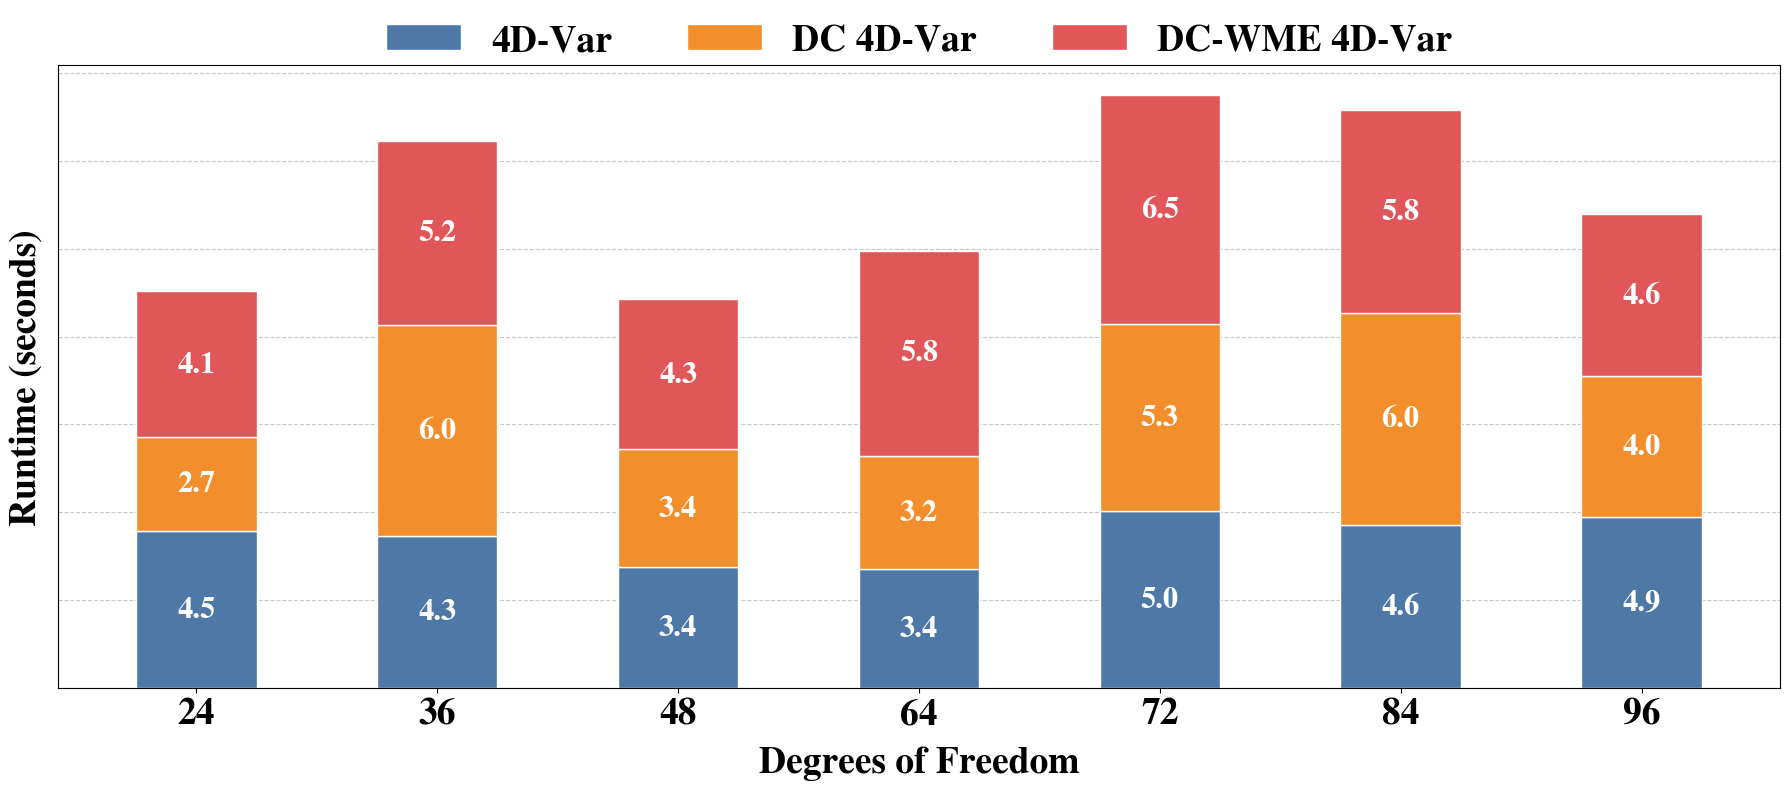

In [33]:
# Extract comp_costs for plotting
degrees_of_freedom = list(comp_costs.keys())
methods = ['Bayes', 'DCI', 'DCI_WME']

# Create arrays for each method
bayes_times = [comp_costs[dof]['Bayes'] for dof in degrees_of_freedom]
dci_times = [comp_costs[dof]['DCI'] for dof in degrees_of_freedom]
dci_wme_times = [comp_costs[dof]['DCI_WME'] for dof in degrees_of_freedom]

# Set up the stacked bar chart
x = np.arange(len(degrees_of_freedom))  # the label locations
width = 0.6  # width of the bars (wider for single stacked bars)

# Plot parameters
plot_params = {
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 27,
    "legend.frameon": False,
    "xtick.labelsize": 27,
    "ytick.labelsize": 27,
    "axes.labelsize": 27,
    "axes.labelpad": 10,
    "figure.figsize": (18, 8),
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'mathtext.default': 'bf',
    'font.family': 'STIXGeneral',
    'font.weight': 'bold',
}

save = True
colors = {
    "Bayes": "#4E79A7",     # Blue
    "DCI": "#F28E2B",       # Orange
    "DCI_WME": "#E15759",   # Red
}
sns.set_palette("bright")
width = 0.5  # slightly narrower for better separation

with plt.rc_context(plot_params):
    fig, ax = plt.subplots()

    # Stacked bars
    bars1 = ax.bar(x, bayes_times, width, label='4D-Var',
                   color=colors["Bayes"], edgecolor='white', linewidth=1)
    bars2 = ax.bar(x, dci_times, width, bottom=bayes_times, label='DC 4D-Var',
                   color=colors["DCI"], edgecolor='white', linewidth=1)
    bottoms = [bayes_times[i] + dci_times[i] for i in range(len(bayes_times))]
    bars3 = ax.bar(x, dci_wme_times, width, bottom=bottoms, label='DC-WME 4D-Var',
                   color=colors["DCI_WME"], edgecolor='white', linewidth=1)

    # Annotate segments + total
    for i in range(len(x)):
        y_base = 0
        for val, color in zip([bayes_times[i], dci_times[i], dci_wme_times[i]], colors.values()):
            ax.text(x[i], y_base + val / 2, f'{val:.1f}', ha='center', va='center',
                    fontsize=22, fontweight='bold', color='white')
            y_base += val

    # Axes labels
    ax.set_xlabel('Degrees of Freedom', fontweight="bold")
    ax.set_ylabel('Runtime (seconds)', fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(degrees_of_freedom)

    # remove y ticks
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)



    # Legend on top
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', linewidth=0.8, alpha=0.7)
    ax.set_axisbelow(True)


    plt.tight_layout()
    if save:
        plt.savefig('figures/comp_cost_plot_l96.png')
    plt.show()